In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas_datareader.data as web
from dateutil.relativedelta import relativedelta
import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

/usr/local/lib/python3.5/dist-packages/ipywidgets/widgets/widget.py:281: DeprecationWarning:

Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.



In [2]:
def veri_al(hisse_kodu,res="yahoo"):
    baslangic = datetime.date.today() - relativedelta(years=yil)
    bitis = datetime.date.today()
    df = web.DataReader(hisse_kodu, res, baslangic, bitis).dropna()   
    return df

In [20]:
train = True
hisse_kodu = 'ISCTR.IS'
yil = 5 # 5 yıllık hisse verisi ile model eğitiyoruz
ay = 3  # 3 aylık trend kestirimi yapıyoruz
np.random.seed(13)

In [4]:
hisse_verisi = veri_al(hisse_kodu)
orgDatLen = hisse_verisi.shape[0]

In [5]:
# Facebook research prophet kütüphanesi linear growth için tarih 'ds' ve değer 'y' kolonuna ihtiyaç duymakta
hisse_verisi = hisse_verisi.reset_index().rename(columns={'Date':'ds', 'Adj Close':'y', 'Volume': 'cap'})
hisse_verisi['y'] = np.log(hisse_verisi['y'])

In [21]:
# Trend kestirimi yapmak üzere mevcut veri ilk tarihi ile başlayan gelecek veri son tarihi ile biten tablo tasarlıyoruz
# Örneğimizde haftasonları için kestirim yapmayacağımız için tabloyu iş günü cinsinden pandas'ın bdate_range ile oluşturduk
# haftasonu ayrımımız olmasaydı future = model.make_future_dataframe(periods=365) komutu ile otomatik üretebilirdik.
future = pd.DataFrame()
future['ds'] = pd.bdate_range(hisse_verisi['ds'][0], pd.datetime.today()+pd.DateOffset(months=ay))

In [22]:
%%time
# Train parametresine göre train edip kaydediyoruz yada load yapıp devam ediyoruz.
model = Prophet(daily_seasonality=False,changepoint_prior_scale=1)
if train:
    model.fit(hisse_verisi)
    with open(hisse_kodu+".model", "wb") as f:
        pickle.dump(model, f)
else:
    with open(hisse_kodu+".model", "rb") as f:
        model = pickle.load(f)

CPU times: user 2.74 s, sys: 0 ns, total: 2.74 s
Wall time: 2.8 s


In [23]:
%%time
forecast = model.predict(future)

CPU times: user 11.8 s, sys: 11.1 s, total: 22.9 s
Wall time: 15.5 s


In [24]:
# Plotly ile browserda incelemek üzere interaktif chart üretiyoruz
# Modelin 'ay' parametresi süresi için %80 güvendiği trend kestirim aralığı
figure = py.iplot({"data": [
    go.Scatter(x=hisse_verisi['ds'], y=np.exp(hisse_verisi['y']), name='Fiyat'),
    go.Scatter(x=forecast['ds'], y=np.exp(forecast['yhat']), name='Tahmin'),
    go.Scatter(x=forecast['ds'], y=np.exp(forecast['yhat_upper']), fill='tonexty', name='Üst sınır'),
    go.Scatter(x=forecast['ds'], y=np.exp(forecast['yhat_lower']), fill='tonexty', name='Alt sınır'),
    go.Scatter(x=forecast['ds'], y=np.exp(forecast['trend']), name='Trend')]})

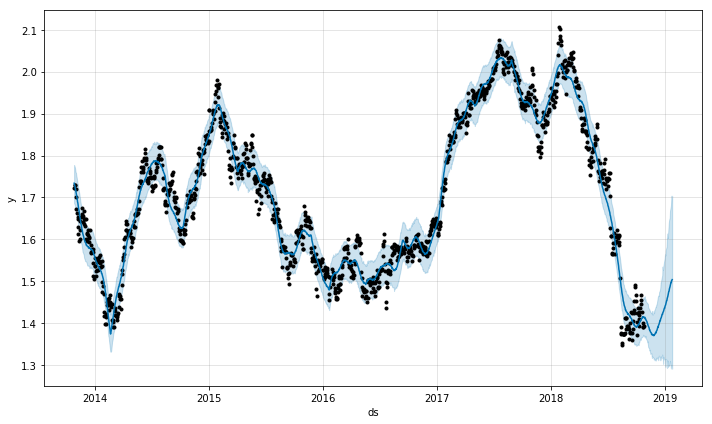

In [26]:
# Modelin 'ay' parametresi süresi için %80 güvendiği trend kestirim aralığı
chart = model.plot(forecast)

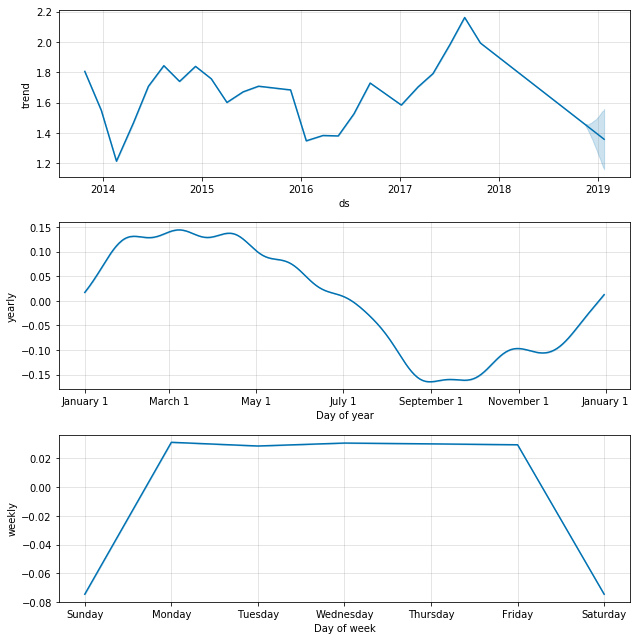

In [27]:
# Modelin 'ay' parametresi süresi için %80 güvendiği trend kestirim aralığı
components = model.plot_components(forecast)

In [28]:
# 66 günlük pencereyi varsayılan durumda 33 günlük periyod ile toplam veri içerisinden örnekleyerek validasyon yapıyoruz
# period parametresi ile validasyon örneği alınacak periyodları elle de belirleyebilirsiniz.
cv = cross_validation(model, horizon = '66 days')

INFO:fbprophet.diagnostics:Making 48 forecasts with cutoffs between 2014-05-22 00:00:00 and 2018-08-20 00:00:00


In [29]:
p = performance_metrics(cv)
p.head()

,horizon,mse,rmse,mae,mape,coverage
1366,7 days,0.005304,0.072826,0.048197,0.027885,0.475556
1838,7 days,0.005308,0.072857,0.048290,0.027933,0.475556
1696,7 days,0.005289,0.072724,0.048060,0.027814,0.480000
849,7 days,0.005222,0.072261,0.047515,0.027490,0.484444
4,7 days,0.006726,0.082011,0.049998,0.028893,0.484444


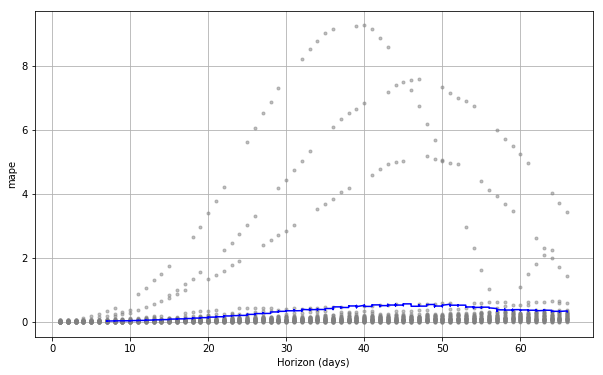

In [30]:
# Validasyon kriteri olarak Mean Absolute Percentage Error'ü baz alıyor ve görsele yansıtıyoruz
fig = plot_cross_validation_metric(cv, metric='mape')

In [31]:
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:orgDatLen, 'yhat']-hisse_verisi['y'])**2)) )

RMSE: 0.034885


In [32]:
bugun_tahmini = forecast.loc[:orgDatLen+2].tail(3)[['ds','yhat']]
bugun_tahmini['yhat'] = np.exp(bugun_tahmini['yhat'])
bugun_tahmini['ds'] = bugun_tahmini['ds'].astype(str)
print("{0} tahmini: %{1:,.4f}".format((bugun_tahmini['ds'].values[1])
                                      ,bugun_tahmini['yhat'].pct_change().values[1]*100))
print("{0} tahmini: %{1:,.4f}".format((bugun_tahmini['ds'].values[2])
                                      ,bugun_tahmini['yhat'].pct_change().values[2]*100))

2018-10-25 tahmini: %-0.0441
2018-10-26 tahmini: %-0.0727
